In [1]:
import cdsapi
import os
import xarray as xr
import numpy as np
from eofs.xarray import Eof
from eofs.examples import example_data_path
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ridge_regression
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cmticker  # for formatters
import matplotlib.ticker as mticker     # for tick locators


In [2]:
# setting parameters
winter_months = [11,12,1,2]

### Downloading ERA5 sea surface temperature data from Copernicus using CDSAPI

In [3]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        #"total_column_water_vapour",
        "land_sea_mask"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [63, 142, 38, -125]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'north_pac_sst.nc')

2025-12-08 03:06:34,850 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-08 03:06:35,313 INFO Request ID is 55f10484-658f-411e-8e34-6609f29512d4
2025-12-08 03:06:35,494 INFO status has been updated to accepted
2025-12-08 03:06:44,196 INFO status has been updated to running
2025-12-08 03:06:49,404 INFO status has been updated to successful


5b7daa4f46082a4e89c96a2774cdf6c2.nc:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

'north_pac_sst.nc'

In [3]:
ds = xr.load_dataset('north_pac_sst.nc')

In [4]:
ds

<xarray.Dataset> Size: 166MB
Dimensions:     (valid_time: 552, latitude: 101, longitude: 373)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 808B 63.0 62.75 62.5 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 3kB 142.0 142.2 142.5 ... 234.5 234.8 235.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    sst         (valid_time, latitude, longitude) float32 83MB nan nan ... 286.6
    lsm         (valid_time, latitude, longitude) float32 83MB 0.9996 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-07T17:35 GRIB to CDM+CF via cfgrib-0.9.1...

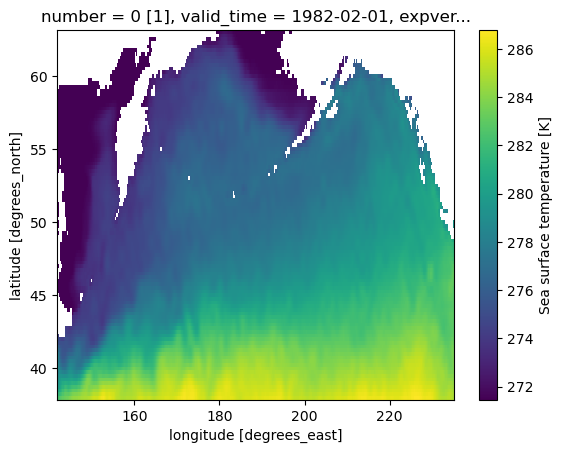

In [5]:
ds['sst'].sel(valid_time='1982-02-01').plot()

In [6]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")


def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)


def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [7]:
detr = linear_detrend(ds[["sst"]], time_dim="valid_time")

Text(0.5, 1.0, 'SST with trend')

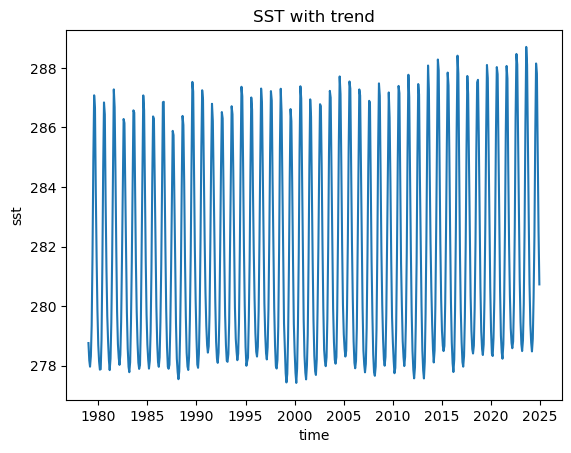

In [11]:
# plot of surface temperature
ds['sst'].mean(dim=('latitude','longitude')).plot()

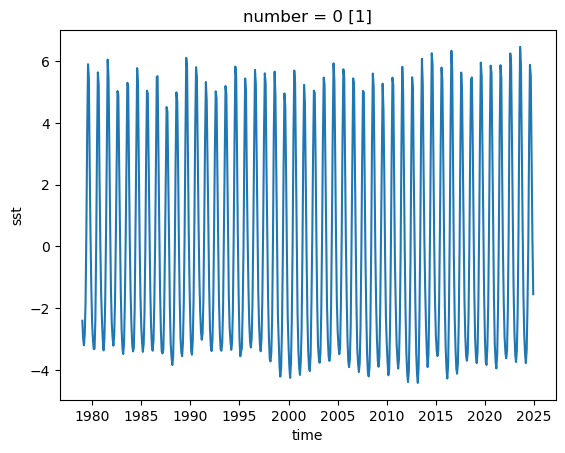

In [9]:
# plot of detrended surface anomalies
detr['sst'].mean(dim=('latitude','longitude')).plot()

In [12]:
# calculating anomalies from detrended data
anom, z = monthly_anom_and_z(detr, time_dim="valid_time")

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

In [13]:
# creating sea surface anomaly data arra yand preparing data array 
anom_sst = anom['sst']
anom_sst = anom_sst.rename({"valid_time": "time"})
# selecting winter months
anom_sst_winter = anom_sst.where(anom_sst['time'].dt.month.isin(winter_months), drop=True)

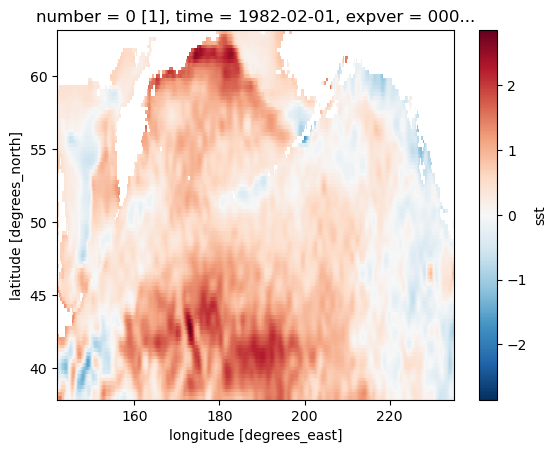

In [14]:
anom_sst.sel(time='1982-02-01').plot()

In [15]:
# creating the weights and creating the solver
coslat = np.cos(np.deg2rad(anom_sst_winter.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(anom_sst, weights=wgts)

In [16]:
eof = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

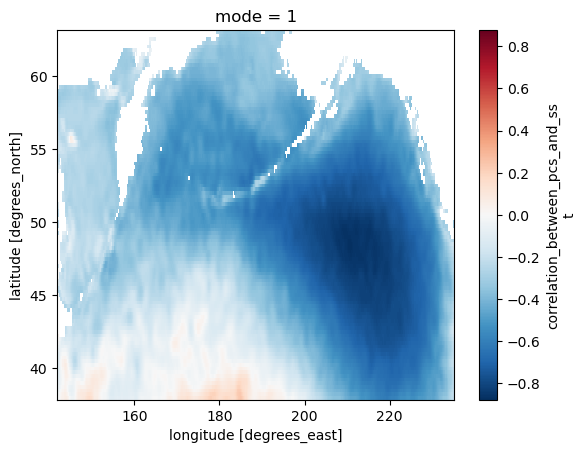

In [17]:
# plotting the first EOF
eof_1 = eof[1]
eof_1.plot()

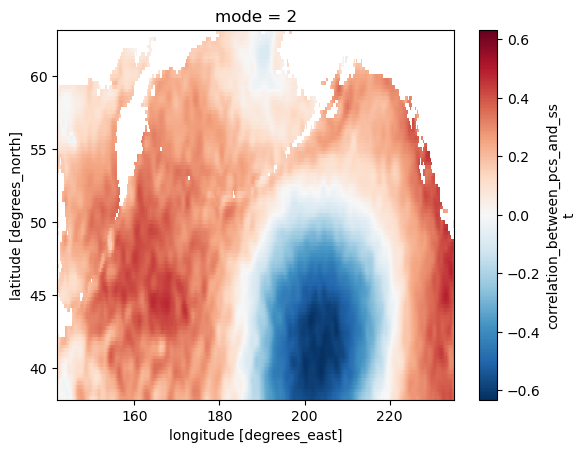

In [18]:
# plotting the second EOF
eof_2 = eof[2]
eof_2.plot()

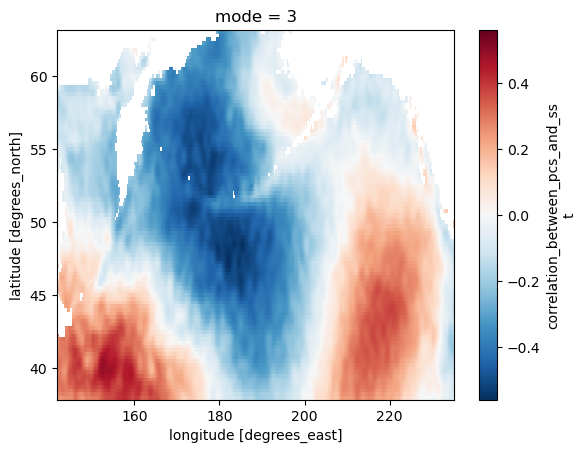

In [19]:
eof[3].plot()

In [20]:
varfrac = solver.varianceFraction()

(6.889364181712125e-16, 0.2322438657283783)

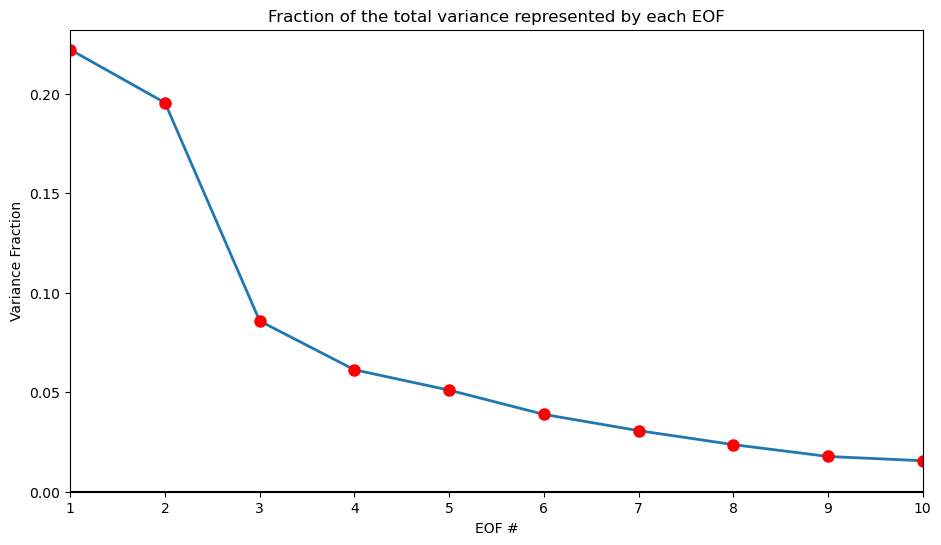

In [21]:
# Plot the percent of variance explained by the first 10 EOFs.
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

Text(0.5, 1.0, 'EOF 1 with the area of variance')

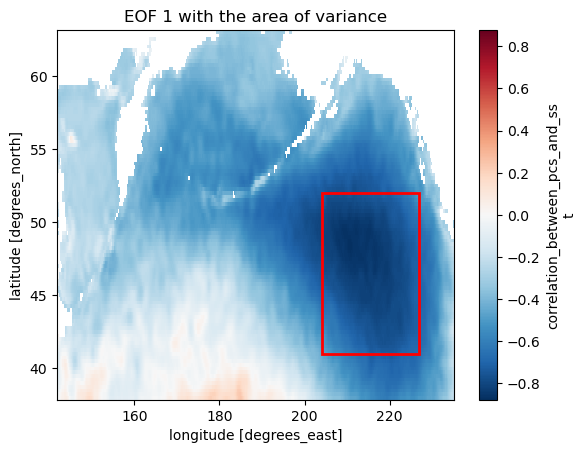

In [22]:
fig, ax = plt.subplots()
im = eof_1.plot()

lon_min, lon_max = 204,227
lat_min, lat_max = 41,52
width = lon_max - lon_min
height = lat_max - lat_min


rect = Rectangle(
    (lon_min, lat_min), width, height,
    linewidth=2, edgecolor='red', facecolor='none')

ax.add_patch(rect)

ax.set_title("EOF 1 with the area of variance")


Text(0.5, 1.0, 'SST region of area with high variance')

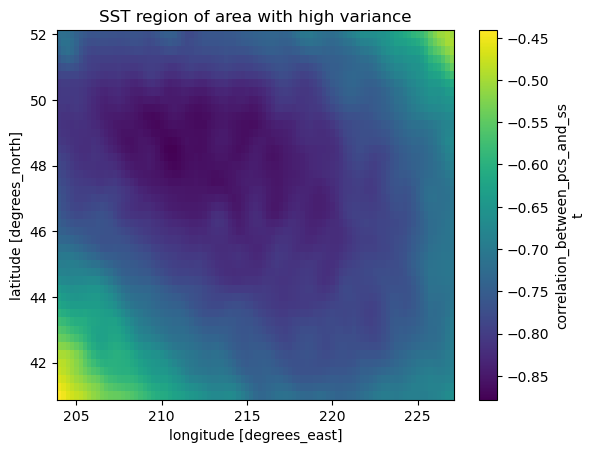

In [23]:
# Zoomed in window of high variance
eof_1.sel(longitude=slice(204,227),latitude=slice(52,41)).plot()
plt.title("SST region of area with high variance")

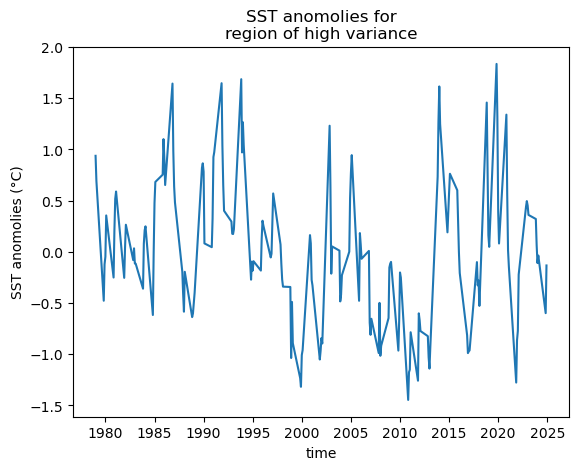

In [26]:
anom_sst_winter.sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude')).plot()
plt.title("SST anomolies for\nregion of high variance")
plt.ylabel("SST anomolies (°C)")
anom_sst_winter_mean = anom_sst.sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude'))


### Downloading ERA5 2 meter temperature data from Copernicus using CDSAPI

In [31]:
dataset = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["total_precipitation",
                 "2m_temperature"],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022", "2023", "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [49, -124, 23, -66]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'usa_tp_t2m_sst.nc')

2025-12-08 03:13:29,712 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-08 03:13:30,016 INFO Request ID is ec9ca015-b662-4744-a47e-217ac68c23a7
2025-12-08 03:13:30,172 INFO status has been updated to accepted
2025-12-08 03:13:44,079 INFO status has been updated to running
2025-12-08 03:13:51,804 INFO status has been updated to successful


3f23cbc46874410afbfe9eea53cedcb2.nc:   0%|          | 0.00/257M [00:00<?, ?B/s]

'usa_tp_t2m_sst.nc'

In [17]:
ds_us = xr.load_dataset('usa_tp_t2m_sst.nc')

In [18]:
ds_us

<xarray.Dataset> Size: 655MB
Dimensions:     (valid_time: 540, latitude: 261, longitude: 581)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 2kB 49.0 48.9 48.8 48.7 ... 23.2 23.1 23.0
  * longitude   (longitude) float64 5kB -124.0 -123.9 -123.8 ... -66.1 -66.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    tp          (valid_time, latitude, longitude) float32 328MB 0.002771 ... nan
    t2m         (valid_time, latitude, longitude) float32 328MB 269.7 ... nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-05T00:40 GRIB to CDM+CF via cfgrib-0.9.1...

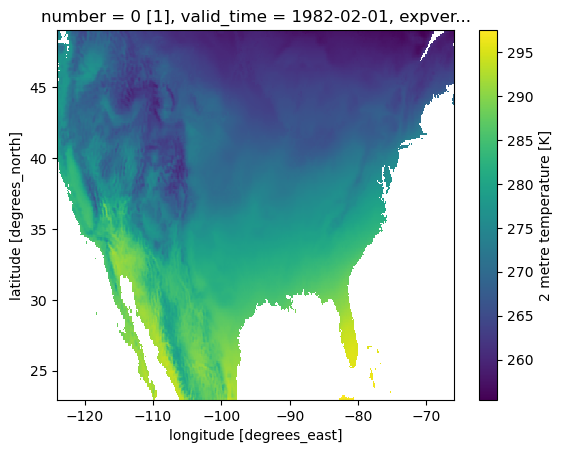

In [19]:
ds_us['t2m'].sel(valid_time='1982-02-01').plot()

In [20]:
detr_us = linear_detrend(ds_us[["tp","t2m"]], time_dim="valid_time")

In [21]:
# calculating the anomalies from the detrended temperature data
anom_us, z_us = monthly_anom_and_z(detr_us, time_dim="valid_time")

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

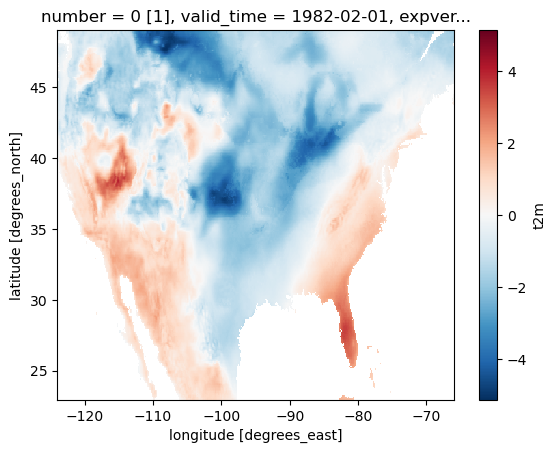

In [24]:
anom_us['t2m'].sel(valid_time='1982-02-01').plot()

In [22]:
z_t2m = z_us['t2m']
anom_t2m = anom_us['t2m']
z_t2m = z_t2m.rename({"valid_time": "time"})
anom_t2m = anom_t2m.rename({"valid_time": "time"})
z_t2m_winter = z_t2m.sel(time=z_t2m.time.dt.month.isin(winter_months))
anom_t2m_winter = anom_t2m.sel(time=anom_t2m.time.dt.month.isin(winter_months))


In [23]:
coslat = np.cos(np.deg2rad(anom_t2m_winter.coords['latitude'].values))
wgts_t2m = np.sqrt(coslat)[..., np.newaxis]

### Calcalculating the correlation between the SST anomolies from the area of high variance with U.S. 2 meter temperature  

In [27]:
out_corr = xr.corr(anom_sst_winter.sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude')), 
                    anom_t2m_winter,dim='time')

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
pca_corr = xr.corr(pc1,anom_t2m_winter,dim='time')

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, '')

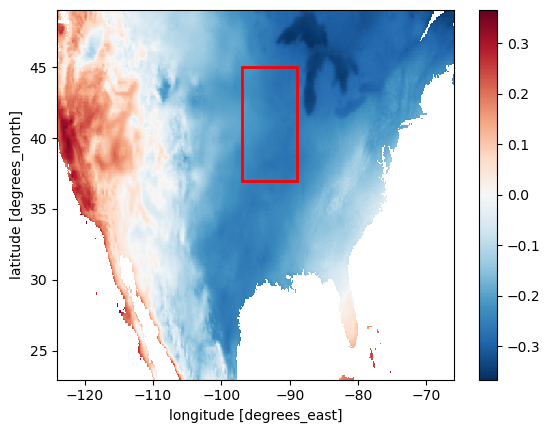

In [28]:
fig, ax = plt.subplots()
im = out_corr.plot()

lon_min, lon_max = -97,-89
lat_min, lat_max = 37,45
width = lon_max - lon_min
height = lat_max - lat_min


rect = Rectangle(
    (lon_min, lat_min), width, height,
    linewidth=2, edgecolor='red', facecolor='none')

ax.add_patch(rect)

ax.set_title("")

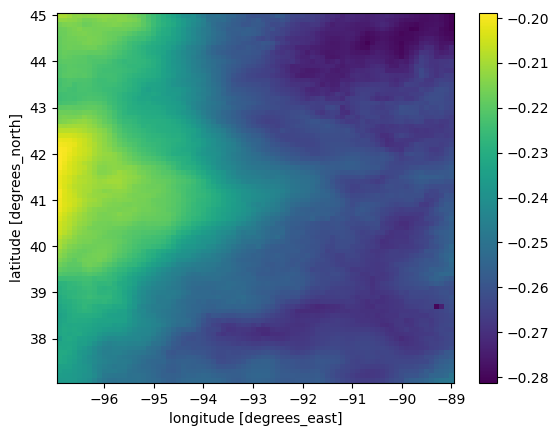

In [43]:
out_corr.sel(latitude=slice(45,37),longitude=slice(-97,-89)).plot()

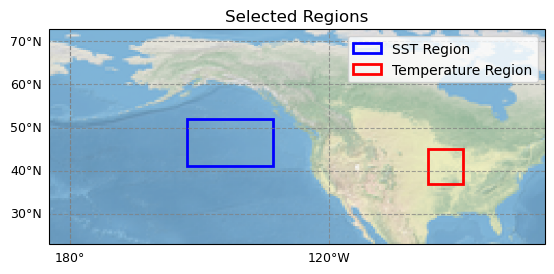

In [107]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.stock_img()
ax.set_extent([-70, 175, 23, 60])

# Add gridlines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),      # gridlines in lon/lat
    draw_labels=True,            # draw labels on the axes
    linewidth=0.8,
    color='gray',
    alpha=0.7,
    linestyle='--'
)
# Control which labels appear (avoid clutter)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}
# Format labels as lon/lat with degree symbols
gl.xformatter = cmticker.LongitudeFormatter()
gl.yformatter = cmticker.LatitudeFormatter()


lon_min1, lon_max1 = -153, -133
lat_min1, lat_max1 = 41, 52

rect_sst = Rectangle(
    (lon_min1, lat_min1),
    lon_max1 - lon_min1,
    lat_max1 - lat_min1,
    edgecolor='blue',
    facecolor='none',
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label="SST Region"
)
lon_min2, lon_max2 = -97,-89
lat_min2, lat_max2 = 37,45

rect_temp = Rectangle(
    (lon_min2, lat_min2),
    lon_max2 - lon_min2,
    lat_max2 - lat_min2,
    edgecolor='red',
    facecolor='none',
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label='Temperature Region'      
)
ax.add_patch(rect_sst)
ax.add_patch(rect_temp)

plt.title("Selected Regions")

plt.legend()
plt.show()

In [26]:
# subsetting for the select areas
t2m_anom_sub = anom_t2m_winter.sel(latitude=slice(45,35),longitude=slice(-97,-90))
sst_anom_sub = anom_sst_winter.sel(longitude=slice(204,227),latitude=slice(52,41))
sst_anom_sub = sst_anom_sub.where(sst_anom_sub.time.dt.year != 2012, drop=True)

Text(0.5, 0, 'SST anomaly\nfor Northern Pacific selected region (°C)')

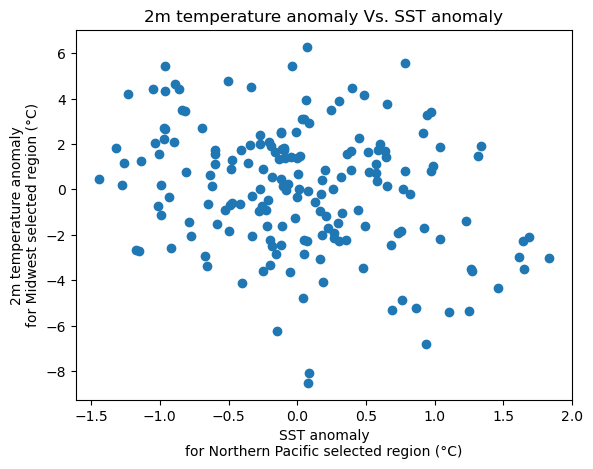

In [28]:
sst_mean = sst_anom_sub.mean(dim=['latitude','longitude'])
t2m_mean = t2m_anom_sub.mean(dim=['latitude','longitude'])
plt.scatter(sst_mean,t2m_mean)
plt.title("2m temperature anomaly Vs. SST anomaly")
plt.ylabel('2m temperature anomaly\nfor Midwest selected region (°C)')
plt.xlabel('SST anomaly\nfor Northern Pacific selected region (°C)')


### Creating linear relationship between the average anomalies in the selected regions

In [29]:
X = np.array(sst_mean).reshape(-1, 1)
y = np.array(t2m_mean)
reg = LinearRegression().fit(X, y)

print("Coef:", reg.coef_, "Intercept:", reg.intercept_)
print("R^2 (test):", reg.score(X, y))
r2 =round(reg.score(X, y),3)


Coef: [-1.0215774] Intercept: 0.0186935
R^2 (test): 0.06790465116500854


In [32]:
pred = reg.predict(X)

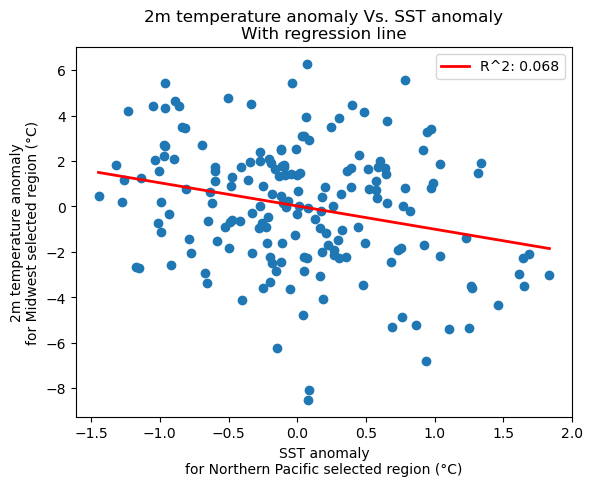

In [30]:
sst_mean = sst_anom_sub.mean(dim=['latitude','longitude'])
t2m_mean = t2m_anom_sub.mean(dim=['latitude','longitude'])
plt.scatter(sst_mean,t2m_mean)
plt.title("2m temperature anomaly Vs. SST anomaly\nWith regression line")
plt.ylabel('2m temperature anomaly\nfor Midwest selected region (°C)')
plt.xlabel('SST anomaly\nfor Northern Pacific selected region (°C)')

x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_line = reg.predict(x_line)
plt.plot(x_line, y_line, color="red", linewidth=2, label="R^2: {}".format(r2))
plt.legend()



### Downloading SST forecast anomalies

In [35]:
import cdsapi

dataset = "seasonal-postprocessed-single-levels"
request = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": ["sea_surface_temperature_anomaly"],
    "product_type": ["ensemble_mean"],
    "year": ["2025"],
    "month": ["11"],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": [63, 142, 38, -125]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'sst_anomoly_forecast.nc')


2025-12-10 02:56:14,210 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-10 02:56:14,990 INFO Request ID is 2908904b-7bd3-49b5-9b27-a351297634d3
2025-12-10 02:56:15,149 INFO status has been updated to accepted
2025-12-10 02:56:36,796 INFO status has been updated to successful


837dd572930b3342e820136041b07046.nc:   0%|          | 0.00/59.8k [00:00<?, ?B/s]

'sst_anomoly_forecast.nc'

In [36]:
sst_fc = xr.load_dataset('sst_anomoly_forecast.nc')

In [32]:
sst_fc

<xarray.Dataset> Size: 12kB
Dimensions:                  (forecast_reference_time: 1, forecastMonth: 6,
                              latitude: 26, longitude: 18)
Coordinates:
    number                   int64 8B 0
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2025...
  * forecastMonth            (forecastMonth) int64 48B 1 2 3 4 5 6
  * latitude                 (latitude) float64 208B 63.0 62.0 ... 39.0 38.0
  * longitude                (longitude) float64 144B -142.0 -141.0 ... -125.0
Data variables:
    ssta                     (forecast_reference_time, forecastMonth, latitude, longitude) float32 11kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-09T03:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
coslat = np.cos(np.deg2rad(sst_fc.coords['latitude'].values))
wgts_sst_fc = np.sqrt(coslat)[..., np.newaxis]

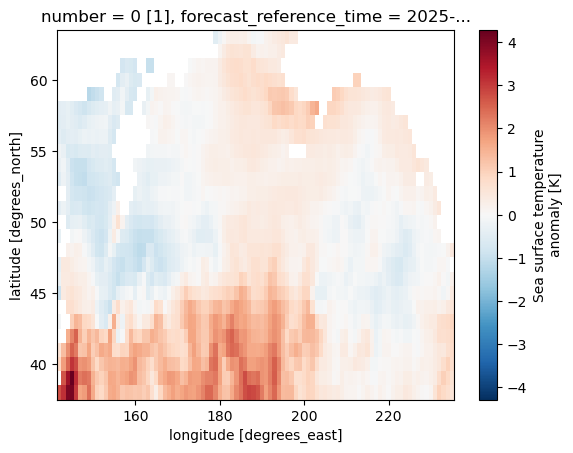

In [37]:
sst_fc['ssta'].sel(forecastMonth=1).plot()

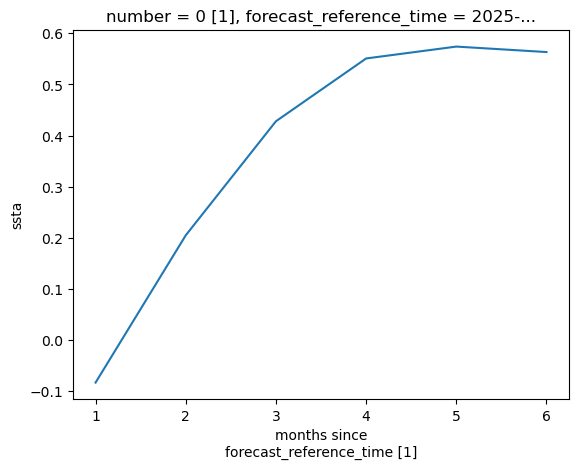

In [38]:
sst_fc['ssta'].sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude')).plot()
sst_fc_mean = sst_fc['ssta'].sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude'))

In [43]:
sst_fc_pred = reg.predict(np.array(sst_fc_mean.values).reshape(-1,1))



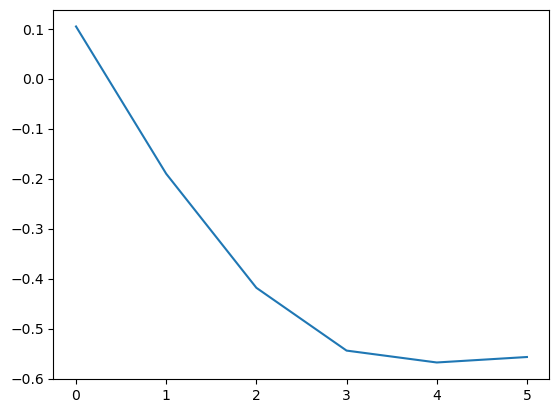

In [46]:
plt.plot(sst_fc_pred)